In [1]:
!pip install -q torch==2.1.2 torchvision==0.16.2 torchaudio==2.1.2 \
               transformers==4.44.2 tokenizers==0.19.1 accelerate==0.27.2 \
               datasets==2.14.6 pillow==9.5.0 opencv-python==4.7.0.72 \
               matplotlib==3.7.1 requests==2.31.0 git+https://github.com/IDEA-Research/GroundingDINO.git@main

  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement torch==2.1.2 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0, 2.9.0)
ERROR: No matching distribution found for torch==2.1.2


In [6]:
import os, re, time, tempfile
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import patches
from transformers import (
    BlipProcessor, BlipForConditionalGeneration,
    AutoProcessor, GroundingDinoForObjectDetection,
    Blip2Processor, Blip2ForConditionalGeneration
)

from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float16 if DEVICE == "cuda" else torch.float32

In [2]:
cap_model_id = "Salesforce/blip-image-captioning-base"
cap_proc = BlipProcessor.from_pretrained(cap_model_id)
cap_model = BlipForConditionalGeneration.from_pretrained(cap_model_id).to(DEVICE).eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [3]:
dino_id = "IDEA-Research/grounding-dino-tiny"
dino_proc = AutoProcessor.from_pretrained(dino_id)
dino_model = GroundingDinoForObjectDetection.from_pretrained(dino_id).to(DEVICE).eval()

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

In [9]:
vqa_model_id = "Salesforce/blip2-opt-2.7b"
vqa_processor = Blip2Processor.from_pretrained(vqa_model_id)
vqa_model = Blip2ForConditionalGeneration.from_pretrained(
    vqa_model_id, dtype=DTYPE, device_map="auto"
).eval()

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [10]:
def get_caption(image: Image.Image):
    inputs = cap_proc(images=image, text="A satellite photo showing", return_tensors="pt").to(DEVICE)
    with torch.inference_mode():
        out = cap_model.generate(**inputs, max_new_tokens=40, num_beams=3)
    return cap_proc.decode(out[0], skip_special_tokens=True).strip().capitalize()

In [11]:
def extract_objects_from_caption(caption):
    nouns = re.findall(r"\b[A-Za-z]{3,}\b", caption.lower())
    ignore = {"the", "and", "with", "near", "view", "photo", "satellite", "image", "showing", "area", "region"}
    nouns = [n for n in nouns if n not in ignore]
    unique = sorted(set(nouns))
    return ", ".join(unique[:7]) if unique else "objects"

In [19]:
def run_dino(image, query=None, threshold=0.1, text_threshold=0.1):
    if not query:
        query = "buildings, roads, ships, docks, water, vehicles, vegetation, bridges"

    inputs = dino_proc(images=image, text=query, return_tensors="pt").to(DEVICE)
    with torch.inference_mode():
        outputs = dino_model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]]).to(DEVICE)
    try:
        post = dino_proc.post_process_grounded_object_detection(
            outputs, target_sizes=target_sizes, box_threshold=threshold, text_threshold=text_threshold
        )[0]
    except TypeError:
        post = dino_proc.post_process_grounded_object_detection(
            outputs, target_sizes=target_sizes, threshold=threshold
        )[0]

    boxes = post["boxes"].cpu()
    scores = post["scores"].cpu()
    labels = post.get("text_labels", post.get("labels", []))

    if boxes.numel() == 0:
        print("⚠️ No objects detected above threshold.")
        return [], None

    if boxes.max() <= 1.1:
        w, h = image.size
        boxes = boxes * torch.tensor([w, h, w, h])

    detections = [
        {"label": str(labels[i]), "score": float(scores[i]), "box": boxes[i].tolist()}
        for i in range(len(boxes))
    ]

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(image)
    for det in detections:
        x0, y0, x1, y1 = det["box"]
        rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor="red", facecolor="none")
        ax.add_patch(rect)
        ax.text(x0, y0 - 5, f"{det['label']} ({det['score']:.2f})",
                color="yellow", fontsize=9, weight="bold", backgroundcolor="black")
    ax.axis("off")
    tmp = tempfile.NamedTemporaryFile(delete=False, suffix=".png")
    plt.savefig(tmp.name, bbox_inches="tight", pad_inches=0)
    plt.close(fig)

    print(f"✅ {len(detections)} objects detected.")
    return detections, tmp.name


In [20]:
def vision_query_answer(image, question, max_new_tokens=40):
    if not isinstance(image, Image.Image):
        raise ValueError("Expected PIL.Image")
    t0 = time.time()
    inputs = vqa_processor(images=[image], text=[question],
                           return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(DEVICE, non_blocking=True) for k, v in inputs.items()}
    with torch.no_grad():
        out = vqa_model.generate(**inputs, max_new_tokens=max_new_tokens,
                                 num_beams=3, do_sample=False)
    ans = vqa_processor.decode(out[0], skip_special_tokens=True).strip()
    ans = re.sub(r"\[unused\d+\]", "", ans)
    return ans, time.time() - t0

In [27]:
def run_pipeline(image_path):
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Input Satellite Image")
    plt.show()

    caption = get_caption(image)
    print(f"🛰️ Caption:\n{caption}\n")

    auto_query = extract_objects_from_caption(caption)
    print(f"🔍 Auto-generated detection query:\n{auto_query}\n")

    dets, ann_path = run_dino(image, query=auto_query, threshold=0.15, text_threshold=0.15)

    for d in dets:
        if not d["label"] or d["label"].strip() == "":
            d["label"] = None

    valid_labels = [d["label"] for d in dets if d["label"]]

    if dets:
        print(f"✅ {len(dets)} objects detected.")
        print("📦 Detected:")
        for d in dets:
            lbl = d["label"] if d["label"] else "unspecified region"
            print(f" - {lbl} ({d['score']:.2f})")
        plt.figure(figsize=(7, 7))
        plt.imshow(Image.open(ann_path))
        plt.axis("off")
        plt.title("Auto-Detected Objects (Grounding DINO)")
        plt.show()
    else:
        print("⚠️ No objects detected.\n")

    # --- build a sensible question ---
    if valid_labels:
        obj_list = ", ".join(valid_labels)
        question = f"What can you tell about the {obj_list} visible in this satellite image?"
    elif caption:
        question = f"Based on this satellite image: {caption.lower()}. What can you infer?"
    else:
        question = "Describe the scene in this satellite image."

    answer, latency = vision_query_answer(image, question)

    answer = re.sub(r"(Caption:.*|Detected:.*)", "", answer)
    answer = re.sub(r"(\b\w+\b)(?: \1\b)+", r"\1", answer).strip()

    print(f"❓ Question: {question}\n💬 Answer: {answer}  ({latency:.2f}s)\n")

    print("=" * 70)
    print("🧾 Summary")
    print(f"Caption: {caption}")
    print("Detected Objects:",
          ", ".join([f"{(d['label'] or 'region')}({d['score']:.2f})" for d in dets]) if dets else "None")
    print(f"Answer: {answer}")
    print("=" * 70)

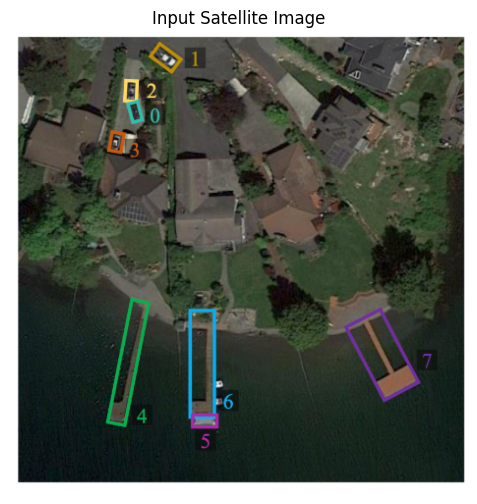

🛰️ Caption:
A satellite photo showing the location of a house in the water

🔍 Auto-generated detection query:
house, location, water

✅ 3 objects detected.
✅ 3 objects detected.
📦 Detected:
 - unspecified region (0.20)
 - unspecified region (0.19)
 - unspecified region (0.15)


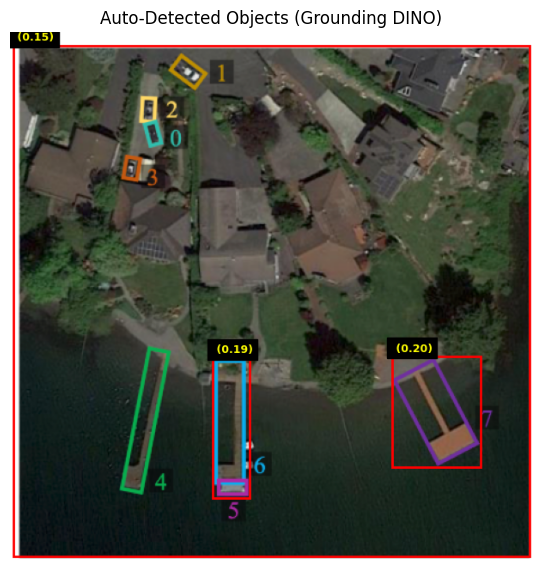

❓ Question: Based on this satellite image: a satellite photo showing the location of a house in the water. What can you infer?
💬 Answer: Based on this satellite image: a satellite photo showing the location of a house in the water. What can you infer? The house is in the water. The house is in the water. The house is in the water. The house is in the water. The house is in the water. The house is in the  (1.34s)

🧾 Summary
Caption: A satellite photo showing the location of a house in the water
Detected Objects: region(0.20), region(0.19), region(0.15)
Answer: Based on this satellite image: a satellite photo showing the location of a house in the water. What can you infer? The house is in the water. The house is in the water. The house is in the water. The house is in the water. The house is in the water. The house is in the


In [28]:
image_path = "/content/Screenshot 2025-11-08 000204.png"
if os.path.exists(image_path):
    run_pipeline(image_path)
else:
    print(f"⚠️ Image not found: {image_path}")